In [1]:
using PyPlot
include("functions.jl");

In [2]:
#The minimum value used in the neut assay
censor_at = log10(20.0)

1.3010299956639813

In [3]:
#These are "paired" - the sample order is assumed to be the same for both
#Log10 domain.
#This is Founder vs Delta data for a prelim run on a subset of samples:
founder_neuts = log10.([59.68,68.65,404.9,162.6,143.2,134.1,60.16,26.64,1047,968.7,2140,3279,630.8,728.7,365.2,251.7,230][1:end])
variant_neuts = log10.([10,10,156.6,39.52,125.2,94.45,20.19,10,542,661.3,784.1,1628,199.6,220.1,102.5,77.44,120.2][1:end]);

In [4]:
#Estimator that just excludes censored samples.
bothmeasured = (founder_neuts .> censor_at) .& (variant_neuts .> censor_at)
10^mean(founder_neuts .- variant_neuts)

2.6903231906864127

In [5]:
#If this is false, then move the censor_at value just a smidgen higher
#or set the values you know to be censored to a value lower than censor_at
mode(variant_neuts) <= censor_at

true

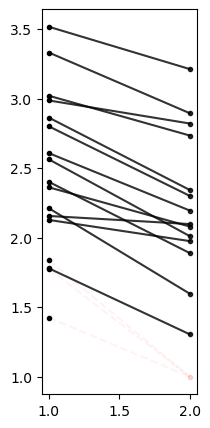

In [6]:
N = length(founder_neuts)
figure(figsize = (2,5))
for i in 1:N
    censored = variant_neuts[i] > censor_at && founder_neuts[i] > censor_at
    d = ifelse(censored,"-","--")
    a = ifelse(censored,0.8,0.05)
    c = ifelse(censored,"black","red")
    plot([1,2],[founder_neuts[i],variant_neuts[i]],d,color = c, alpha = a)
    plot([1],[founder_neuts[i]],".",color = "black")
    plot([2],[variant_neuts[i]],".",alpha = a, color = c)
end

In [7]:
@time chain = MCMC(founder_neuts, variant_neuts, censor_at, maxiters = 10000000);
fold_change_chain = [c[2] for c in chain[1000:end]];
fold_change_HPDs = quantile(fold_change_chain,[0.025,0.5,0.975]);
foldHPDs = 10 .^ fold_change_HPDs

 21.063256 seconds (226.12 M allocations: 19.289 GiB, 8.96% gc time, 3.61% compilation time)


3-element Vector{Float64}:
 2.0155120495452437
 2.5776800555455153
 3.3037045806873904

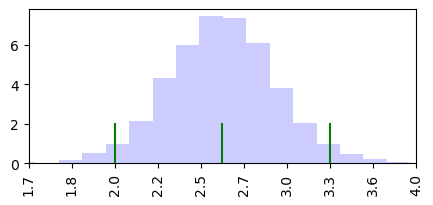

In [8]:
figure(figsize = (5,2))
hist(fold_change_chain,20,density = "true", color = "blue", alpha = 0.2);
for i in 1:3
    plot([fold_change_HPDs[i],fold_change_HPDs[i]],[0.0,2.0], color = "green")
end
t = (fold_change_HPDs[3]-fold_change_HPDs[1])/5
rang = fold_change_HPDs[1]-2t:t:fold_change_HPDs[3]+2t
xticks(rang,round.(10 .^ rang,sigdigits = 2), rotation = 90);
xlim(minimum(rang),maximum(rang));

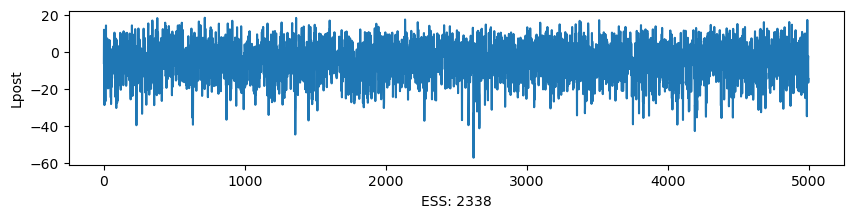

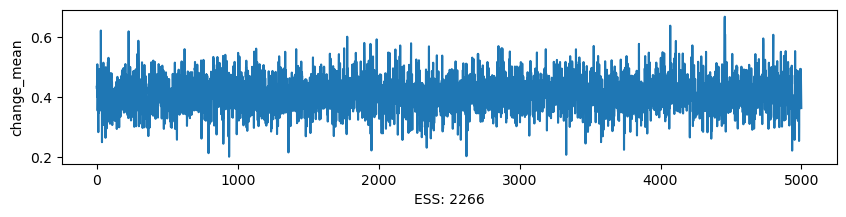

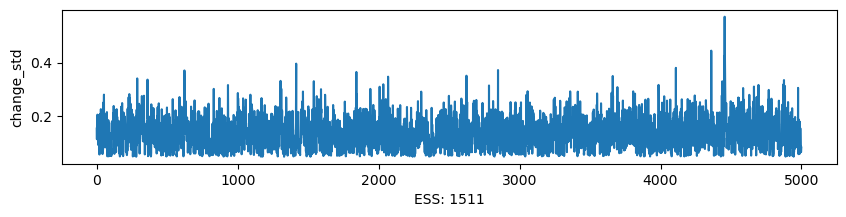

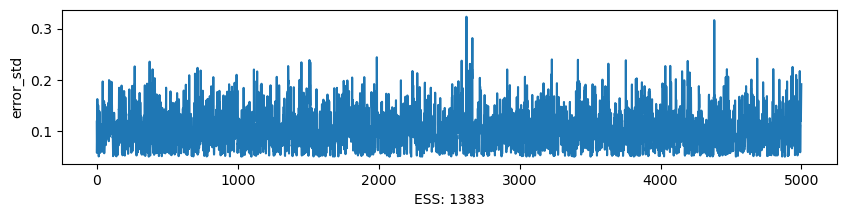

In [9]:
name_list = ["Lpost","change_mean","change_std","error_std"]
for i in 1:4
    figure(figsize = (10,2))
    v = [c[i] for c in chain]
    plot(v)
    xlabel("ESS: "*string(Int64(round(effective_sample_size(v[500:end])))))
    ylabel(name_list[i])
end